In [1]:
import numpy as np
import scipy.stats
from numba import jit
import matplotlib.pyplot as plt
import time
import numpy.fft as fft

hbar = 6.582119569e-16
c = 299792458


In [2]:
''' Functions '''
# source function
def phot_gen(N, E, widthx, widthz, tpulse):
    pulse_length = c * tpulse
    omega = E/hbar
    wavelength = 2*np.pi*c/omega

    # space
    X = scipy.stats.truncnorm(-2.282, 2.282, loc=0, scale=1.0)
    rphoton = np.zeros((N,3))
    rphoton[:,0] = X.rvs(N) * widthx/2.282/2
    rphoton[:,1] = X.rvs(N) * widthz/2.282/2

    # time
    nn = scipy.stats.truncnorm(-2.282, 2.282, loc=0, scale=1.0)			# truncate N(0,1) to 90%
    ns = nn.rvs(N)
    nbins = int(pulse_length/wavelength)					# number of bins

    hist, binedge = np.histogram(ns,bins = nbins)
    pbins = hist/hist.sum()									# probability density in N(0,1)
    tbins = np.arange(nbins); tbins = tbins-tbins.mean()	# tbin index
    tbins = tbins * 2*np.pi / omega							# actual tbins

    tphoton = np.random.choice(tbins, p=pbins, size=N)		# sampling from tbins and pbins

    return rphoton, tphoton

def Ibeam(input):
    return np.square(input.real)+np.square(input.imag)

def NFFT(input):
    return fft.fftshift(fft.fft2(fft.ifftshift(input)))
def INFFT(input):
    return fft.fftshift(fft.ifft2(fft.ifftshift(input)))


In [3]:
''' Parameters '''
# detector
pixel_size = 50    # um
dim_det = 50

detx = (np.arange(dim_det)-(dim_det-1)/2) * pixel_size*1e-6
dety = detx.copy()


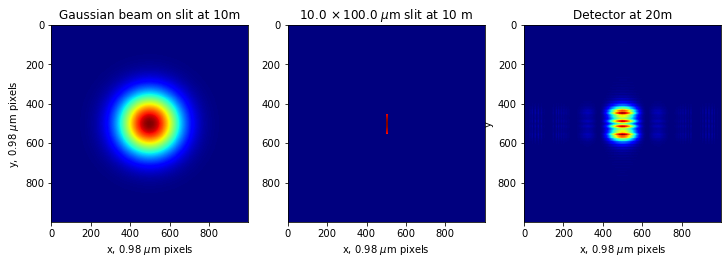

In [16]:
# Gaussian beam
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

sigma_x = 2e-6
sigma_y = 2e-6
dim_source = 1000
z0 = 10

zRx = np.pi*sigma_x**2/wavelength
zRy = np.pi*sigma_y**2/wavelength

wx = sigma_x * np.sqrt(1+(z0/zRx)**2)
wy = sigma_y * np.sqrt(1+(z0/zRy)**2)

wmax = np.amax([wx,wy])
fwhm = 1.18*wmax
FOV = 4*fwhm
dx = FOV/dim_source

x = np.linspace(-dim_source/2,dim_source/2-1,dim_source)*dx
x,y = np.meshgrid(x,x)

phase = np.zeros((dim_source,dim_source))

Rx = z0 * (1+(zRx/z0)**2)
Ry = z0 * (1+(zRy/z0)**2)

phase = 2*np.pi/wavelength * np.sqrt(
    (Rx * (1-np.cos(np.arcsin(x/Rx))))**2+
    (Ry * (1-np.cos(np.arcsin(y/Ry))))**2 )
     
beam_gaus = np.exp(- (x / wx) ** 2 - (y / wy) ** 2) * np.exp(1j * phase)
''' Slit '''
slit_x = 1e1
slit_y = 1e2
window = (np.abs(x)<slit_x/1e6/2) * (np.abs(y)<slit_y/1e6/2)
beam_slit = beam_gaus * window


''' Circ Apperture '''
#slit_r = 1e1
#window = np.square(x)+np.square(y)<np.square(slit_r/1e6)
#beam_slit = beam_gaus*window

''' Drift '''
detz = z0+10

fxMax = 1.0/(2.0*dx)
dfx = fxMax/dim_source
fx = np.linspace(-fxMax, fxMax-dfx, dim_source)
fy = np.copy(fx)
fx, fy = np.meshgrid(fx,fy)

phiProp = k * (np.sqrt( 1.0 - (wavelength*fx)**2 - (wavelength*fy)**2 ))     # k-space kz
filter0 = fx**2 + fy**2 < (1.0/wavelength)**2

#G = NFFT(beam_gaus)
#G = G*np.exp(1j*phiProp*(detz-slitz))*filter0
G = NFFT(beam_slit)
G = G*np.exp(1j*phiProp*(detz-z0))*filter0                # np.exp(i*kz*deltaz)
E_det_Prop = INFFT(G)

I_det_Prop = Ibeam(E_det_Prop)

# plot source at slit
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_gaus),cmap='jet')
#plt.colorbar()
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Gaussian beam on slit at {}m'.format(z0))

plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_slit),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
#plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title(r'{}$\,\times${} $\mu$m slit at {} m'.format(slit_x,slit_y,z0))

# plot drift
plt.subplot(1,3,3)
plt.imshow(I_det_Prop,cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Detector at {}m'.format(detz))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
#plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.savefig('Gaussian_Beam_and_Slit_{}-{}.png'.format(z0,detz),transparent=True)

In [14]:
print('kz',phiProp[0,0])
print('fx',fx[0,0])
print('fy',fy[0,0])

kz 48143441593.947624
fx -509970.4473905254
fy -509970.4473905254


# Work in progress

The following code can not be trusted yet.

Text(0.5, 1.0, 'Beam after mirror')

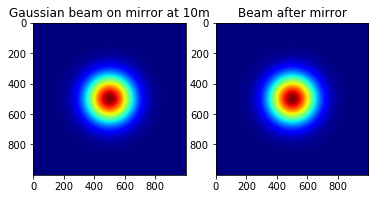

In [63]:
# Mirror
length = 1
alpha = np.deg2rad(45)
mirror_z = z0
direction = 'horizontal'
shapeError = None
delta = 0

projectWidth = np.abs(length*np.sin(alpha+delta))    # width of mirror projected onto beam's transverse direction
N,M = np.shape(x)

shapeError2 = np.zeros(x.shape)
total_error = np.zeros(x.shape)
misalign = np.zeros(x.shape)

if direction == 'horizontal':
    mirror = np.abs(x) < projectWidth
    misalign = delta*x / np.sin(alpha)
elif direction == 'vertical':
    mirror = np.abs(y) < projectWidth
    misalign = delta*y / np.sin(alpha)
total_error = shapeError2 * 1e-9 + misalign

phase = total_error * 4*np.pi * np.sin(alpha) / wavelength
beam_mirror = beam_gaus * mirror * np.exp(1j*phase)

# flat lens beam inversion
if direction == 'horizontal':
    beam_mirror = np.fliplr(beam_mirror)
elif direction == 'vertical':
    beam_mirror = np.flipud(beam_mirror)
    
I_mirror = Ibeam(beam_mirror)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(Ibeam(beam_gaus),cmap='jet')
plt.title('Gaussian beam on mirror at {}m'.format(z0))

plt.subplot(1,2,2)
plt.imshow(I_mirror,cmap='jet')
plt.title('Beam after mirror')

In [ ]:
# curved mirrors
''' this is really hard to code up.... '''